In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

IMAGE_PATH = os.path.abspath(os.getcwd())
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(os.path.abspath(os.getcwd()), fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tf_agents.environments import suite_gym

env = suite_gym.load("ALE/SpaceInvaders-v5")
env

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\gym\utils\seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


In [4]:
print(env.get_info())
print(env.action_spec())
print(env.gym.get_action_meanings())

None
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)
['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Saving figure invader-plot


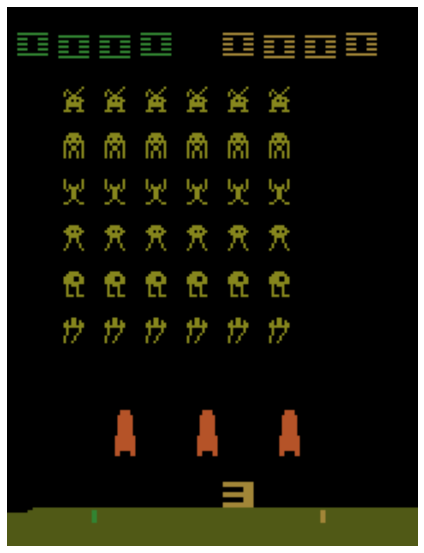

In [5]:
img = env.render(mode="rgb_array")

plt.figure(figsize=(6, 8))
plt.imshow(img)
plt.axis("off")
save_fig("invader-plot")
plt.show()

In [6]:
from tf_agents.environments.wrappers import ActionRepeat
from gym.wrappers import TimeLimit
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

class AtariPreprocessingWithSkipStart(AtariPreprocessing):
    def skip_frames(self, num_skip):
        for _ in range(num_skip):
          super().step(0) # NOOP for num_skip steps
    def reset(self, **kwargs):
        obs = super().reset(**kwargs)
        self.skip_frames(40)
        return obs
    def step(self, action):
        lives_before_action = self.ale.lives()
        obs, rewards, done, info = super().step(action)
        if self.ale.lives() < lives_before_action and not done:
            self.skip_frames(40)
        return obs, rewards, done, info


repeating_env = ActionRepeat(env, times=4)
limited_repeating_env = suite_gym.load(
    "ALE/SpaceInvaders-v5",
    gym_env_wrappers=[lambda env: TimeLimit(env, max_episode_steps=10000)],
    env_wrappers=[lambda env: ActionRepeat(env, times=4)]
)
env = suite_gym.load(
    'ALE/SpaceInvaders-v5',
    max_episode_steps=27000,
    gym_env_wrappers=[AtariPreprocessingWithSkipStart, FrameStack4]
)

In [7]:
import numpy as np

def draw_obs(obs): #Draw the Observation Screen
    obs = obs.astype(np.float32)
    img = obs[..., :3]
    current_frame_delta = np.maximum(obs[..., 3] - obs[..., :3].mean(axis=-1), 0.)
    img[..., 0] += current_frame_delta
    img[..., 2] += current_frame_delta
    img = np.clip(img / 150, 0, 1)
    plt.imshow(img)
    plt.axis("off")


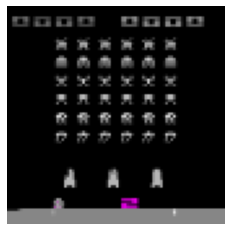

In [8]:
env.seed(32)

env.reset()
for _ in range(4): #Test control and get the trajectory
    time_step = env.step(3)

draw_obs(time_step.observation)
# save_fig('processed_invadar_game_pic')
plt.show()

In [9]:
from tf_agents.environments import TFPyEnvironment
import keras
import tensorflow as tf
from tf_agents.networks.q_network import QNetwork

tf_env = TFPyEnvironment(env)

preprocessing_layer = keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32) / 255.) #Default layer design from book
fc_layer_params = [512]
conv_layer_params = [(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    preprocessing_layers=preprocessing_layer,
    conv_layer_params=conv_layer_params,
    fc_layer_params=fc_layer_params
)


In [10]:
from tf_agents.agents.dqn.dqn_agent import DqnAgent

train_steps = tf.Variable(0)
update_period = 4
optimizer = tf.keras.optimizers.RMSprop(learning_rate=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=250000 // update_period,
    end_learning_rate=0.01)
agent = DqnAgent(
    time_step_spec=tf_env.time_step_spec(),
    action_spec=tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period=2000,
    td_errors_loss_fn=keras.losses.Huber(reduction="none"),
    gamma=0.99,
    train_step_counter=train_steps,
    epsilon_greedy=lambda:epsilon_fn(train_steps)
)
agent.initialize()

In [11]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.replay_buffers.py_hashed_replay_buffer import PyHashedReplayBuffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=500000
)

replay_buffer_observer = replay_buffer.add_batch

In [12]:
class ShowProgress():
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

In [13]:
from tf_agents.metrics import tf_metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric()
]

In [14]:
from tf_agents.eval.metric_utils import log_metrics
import logging

logging.getLogger().setLevel(logging.INFO)
log_metrics(train_metrics)

INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 0
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


In [15]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver

collect_driver = DynamicStepDriver(
    tf_env,
    agent.collect_policy,
    observers=[replay_buffer_observer] + train_metrics,
    num_steps=update_period
)

In [16]:
collect_driver

In [17]:
from tf_agents.policies.random_tf_policy import RandomTFPolicy

initial_collect_policy = RandomTFPolicy(tf_env.time_step_spec(), tf_env.action_spec())

init_driver = DynamicStepDriver(
    tf_env,
    initial_collect_policy,
    observers=[replay_buffer.add_batch, ShowProgress(20000)],
    num_steps=20000
)
final_time_step, final_policy_state = init_driver.run()

20000/20000

In [18]:
trajectories, buffer_info = next(iter(replay_buffer.as_dataset(
    sample_batch_size=2,
    num_steps=3,
    single_deterministic_pass=False)))
print(trajectories)
print(buffer_info)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Trajectory(
{'action': <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[0, 5, 2],
       [3, 1, 5]], dtype=int64)>,
 'discount': <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]])>,
 'observation': <tf.Tensor: shape=(2, 3, 84, 84, 4), dtype=uint8, numpy=
array([[[[[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         [[ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          ...,
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0],
          [ 0,  0,  0,  0]],

         ...,

         [[

In [19]:
print(trajectories._fields)

('step_type', 'observation', 'action', 'policy_info', 'next_step_type', 'reward', 'discount')


In [20]:
print('Shape of \'observation\': ', trajectories.observation.shape)
print('Shape of \'rewards\': ', trajectories.reward.shape)
print(trajectories.step_type.numpy())

Shape of 'observation':  (2, 3, 84, 84, 4)
Shape of 'rewards':  (2, 3)
[[1 1 1]
 [1 1 1]]


Saving figure sub_episode_plot


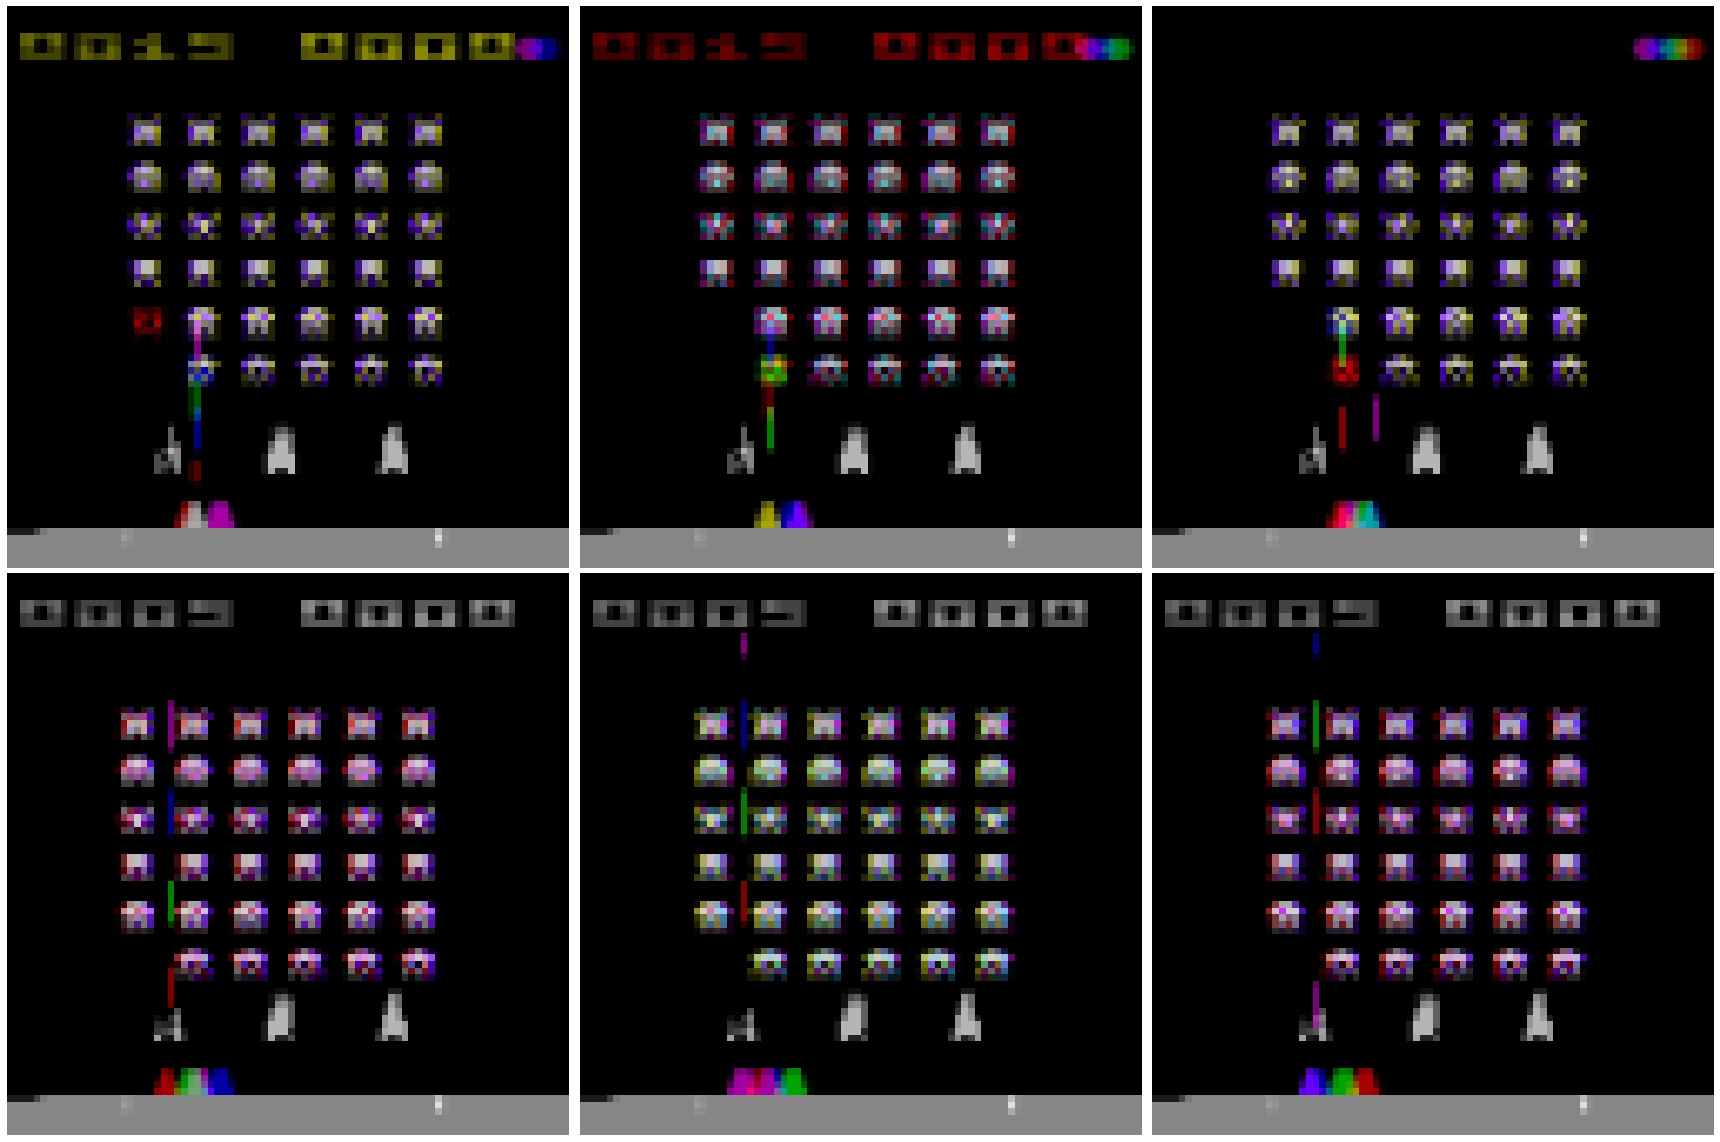

In [21]:
plt.figure(figsize=(24, 16))
for row in range(2):
    for col in range(3):
        plt.subplot(2, 3, row*3 + col+1)
        draw_obs(trajectories.observation[row, col].numpy())
plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0.02)
save_fig('sub_episode_plot')
plt.show()

簡單印出其中兩個 Trajectories

In [22]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=64,
    num_steps=2,
    num_parallel_calls=3).prefetch(3)

In [23]:
from tf_agents.utils.common import function

collect_driver.run = function(collect_driver.run)
agent.train = function(agent.train)


In [24]:
def train_agent(n_iterations):
    time_step = None
    total_return = 0.0
    policy_state = agent.collect_policy.get_initial_state(tf_env.batch_size)
    iterator = iter(dataset)
    for iteration in range(n_iterations):
        time_step, policy_state = collect_driver.run(time_step, policy_state)
        trajectories, buffer_info = next(iterator)
        train_loss = agent.train(trajectories)
        print("\r{} loss:{:.5f}".format(iteration, train_loss.loss.numpy()), end="")
        if (iteration % 1000 == 0):
            # train_checkpointer.save(iteration)
            # saver.save('policy_%d' % iteration)
            log_metrics(train_metrics)

In [26]:
train_agent(400000)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
INFO:absl: 
		 NumberOfEpisodes = 0
		 EnvironmentSteps = 4
		 AverageReturn = 0.0
		 AverageEpisodeLength = 0.0


998 loss:0.69153

INFO:absl: 
		 NumberOfEpisodes = 85
		 EnvironmentSteps = 4004
		 AverageReturn = 64.0
		 AverageEpisodeLength = 51.29999923706055


1999 loss:0.78335

INFO:absl: 
		 NumberOfEpisodes = 172
		 EnvironmentSteps = 8004
		 AverageReturn = 39.0
		 AverageEpisodeLength = 45.099998474121094


2999 loss:0.55592

INFO:absl: 
		 NumberOfEpisodes = 263
		 EnvironmentSteps = 12004
		 AverageReturn = 69.0
		 AverageEpisodeLength = 53.70000076293945


3999 loss:0.38991

INFO:absl: 
		 NumberOfEpisodes = 353
		 EnvironmentSteps = 16004
		 AverageReturn = 77.5
		 AverageEpisodeLength = 55.5


4997 loss:1.04327

INFO:absl: 
		 NumberOfEpisodes = 427
		 EnvironmentSteps = 20004
		 AverageReturn = 76.0
		 AverageEpisodeLength = 41.599998474121094


5998 loss:3.84936

INFO:absl: 
		 NumberOfEpisodes = 495
		 EnvironmentSteps = 24004
		 AverageReturn = 47.0
		 AverageEpisodeLength = 51.0


6997 loss:1.79193

INFO:absl: 
		 NumberOfEpisodes = 582
		 EnvironmentSteps = 28004
		 AverageReturn = 61.0
		 AverageEpisodeLength = 46.5


7999 loss:1.36242

INFO:absl: 
		 NumberOfEpisodes = 676
		 EnvironmentSteps = 32004
		 AverageReturn = 37.5
		 AverageEpisodeLength = 40.400001525878906


8999 loss:0.69847

INFO:absl: 
		 NumberOfEpisodes = 767
		 EnvironmentSteps = 36004
		 AverageReturn = 54.5
		 AverageEpisodeLength = 40.0


9999 loss:1.59888

INFO:absl: 
		 NumberOfEpisodes = 849
		 EnvironmentSteps = 40004
		 AverageReturn = 64.0
		 AverageEpisodeLength = 39.29999923706055


10996 loss:5.52717

INFO:absl: 
		 NumberOfEpisodes = 939
		 EnvironmentSteps = 44004
		 AverageReturn = 52.0
		 AverageEpisodeLength = 39.20000076293945


11998 loss:1.16003

INFO:absl: 
		 NumberOfEpisodes = 1029
		 EnvironmentSteps = 48004
		 AverageReturn = 55.5
		 AverageEpisodeLength = 40.0


12996 loss:1.57185

INFO:absl: 
		 NumberOfEpisodes = 1111
		 EnvironmentSteps = 52004
		 AverageReturn = 61.0
		 AverageEpisodeLength = 44.599998474121094


13997 loss:1.35248

INFO:absl: 
		 NumberOfEpisodes = 1195
		 EnvironmentSteps = 56004
		 AverageReturn = 47.5
		 AverageEpisodeLength = 33.29999923706055


14998 loss:0.95974

INFO:absl: 
		 NumberOfEpisodes = 1274
		 EnvironmentSteps = 60004
		 AverageReturn = 66.0
		 AverageEpisodeLength = 48.79999923706055


15997 loss:1.50160

INFO:absl: 
		 NumberOfEpisodes = 1364
		 EnvironmentSteps = 64004
		 AverageReturn = 89.0
		 AverageEpisodeLength = 50.70000076293945


16999 loss:4.27248

INFO:absl: 
		 NumberOfEpisodes = 1438
		 EnvironmentSteps = 68004
		 AverageReturn = 63.0
		 AverageEpisodeLength = 45.0


17998 loss:1.22234

INFO:absl: 
		 NumberOfEpisodes = 1523
		 EnvironmentSteps = 72004
		 AverageReturn = 80.5
		 AverageEpisodeLength = 47.400001525878906


18998 loss:1.274091

INFO:absl: 
		 NumberOfEpisodes = 1608
		 EnvironmentSteps = 76004
		 AverageReturn = 123.5
		 AverageEpisodeLength = 58.099998474121094


19999 loss:1.36841

INFO:absl: 
		 NumberOfEpisodes = 1673
		 EnvironmentSteps = 80004
		 AverageReturn = 69.5
		 AverageEpisodeLength = 39.599998474121094


20998 loss:2.06648

INFO:absl: 
		 NumberOfEpisodes = 1746
		 EnvironmentSteps = 84004
		 AverageReturn = 93.5
		 AverageEpisodeLength = 60.70000076293945


21997 loss:1.69125

INFO:absl: 
		 NumberOfEpisodes = 1836
		 EnvironmentSteps = 88004
		 AverageReturn = 67.5
		 AverageEpisodeLength = 39.900001525878906


22999 loss:1.33905

INFO:absl: 
		 NumberOfEpisodes = 1904
		 EnvironmentSteps = 92004
		 AverageReturn = 91.5
		 AverageEpisodeLength = 54.900001525878906


23999 loss:1.99822

INFO:absl: 
		 NumberOfEpisodes = 1987
		 EnvironmentSteps = 96004
		 AverageReturn = 103.0
		 AverageEpisodeLength = 55.599998474121094


24997 loss:2.10677

INFO:absl: 
		 NumberOfEpisodes = 2063
		 EnvironmentSteps = 100004
		 AverageReturn = 108.0
		 AverageEpisodeLength = 55.099998474121094


25998 loss:5.02510

INFO:absl: 
		 NumberOfEpisodes = 2142
		 EnvironmentSteps = 104004
		 AverageReturn = 135.5
		 AverageEpisodeLength = 54.0


26998 loss:1.42441

INFO:absl: 
		 NumberOfEpisodes = 2215
		 EnvironmentSteps = 108004
		 AverageReturn = 76.5
		 AverageEpisodeLength = 48.70000076293945


27998 loss:1.93641

INFO:absl: 
		 NumberOfEpisodes = 2295
		 EnvironmentSteps = 112004
		 AverageReturn = 88.0
		 AverageEpisodeLength = 47.900001525878906


28998 loss:3.24567

INFO:absl: 
		 NumberOfEpisodes = 2365
		 EnvironmentSteps = 116004
		 AverageReturn = 140.5
		 AverageEpisodeLength = 51.29999923706055


29996 loss:5.33568

INFO:absl: 
		 NumberOfEpisodes = 2438
		 EnvironmentSteps = 120004
		 AverageReturn = 156.0
		 AverageEpisodeLength = 67.5999984741211


30999 loss:2.73879

INFO:absl: 
		 NumberOfEpisodes = 2508
		 EnvironmentSteps = 124004
		 AverageReturn = 107.5
		 AverageEpisodeLength = 65.5999984741211


31996 loss:5.41235

INFO:absl: 
		 NumberOfEpisodes = 2569
		 EnvironmentSteps = 128004
		 AverageReturn = 136.0
		 AverageEpisodeLength = 52.099998474121094


32999 loss:1.94068

INFO:absl: 
		 NumberOfEpisodes = 2655
		 EnvironmentSteps = 132004
		 AverageReturn = 121.5
		 AverageEpisodeLength = 52.400001525878906


33997 loss:2.63345

INFO:absl: 
		 NumberOfEpisodes = 2737
		 EnvironmentSteps = 136004
		 AverageReturn = 120.0
		 AverageEpisodeLength = 61.70000076293945


34996 loss:2.90004

INFO:absl: 
		 NumberOfEpisodes = 2810
		 EnvironmentSteps = 140004
		 AverageReturn = 80.0
		 AverageEpisodeLength = 42.5


35999 loss:2.39636

INFO:absl: 
		 NumberOfEpisodes = 2892
		 EnvironmentSteps = 144004
		 AverageReturn = 168.5
		 AverageEpisodeLength = 65.80000305175781


36999 loss:2.87660

INFO:absl: 
		 NumberOfEpisodes = 2960
		 EnvironmentSteps = 148004
		 AverageReturn = 99.5
		 AverageEpisodeLength = 47.400001525878906


37997 loss:3.23198

INFO:absl: 
		 NumberOfEpisodes = 3029
		 EnvironmentSteps = 152004
		 AverageReturn = 88.5
		 AverageEpisodeLength = 49.5


38997 loss:2.921712

INFO:absl: 
		 NumberOfEpisodes = 3094
		 EnvironmentSteps = 156004
		 AverageReturn = 131.5
		 AverageEpisodeLength = 61.400001525878906


39998 loss:5.22426

INFO:absl: 
		 NumberOfEpisodes = 3167
		 EnvironmentSteps = 160004
		 AverageReturn = 125.5
		 AverageEpisodeLength = 70.80000305175781


40999 loss:2.84028

INFO:absl: 
		 NumberOfEpisodes = 3254
		 EnvironmentSteps = 164004
		 AverageReturn = 79.0
		 AverageEpisodeLength = 40.5


41998 loss:3.34512

INFO:absl: 
		 NumberOfEpisodes = 3333
		 EnvironmentSteps = 168004
		 AverageReturn = 107.0
		 AverageEpisodeLength = 45.400001525878906


42998 loss:3.606084

INFO:absl: 
		 NumberOfEpisodes = 3400
		 EnvironmentSteps = 172004
		 AverageReturn = 129.5
		 AverageEpisodeLength = 55.20000076293945


43997 loss:4.12746

INFO:absl: 
		 NumberOfEpisodes = 3478
		 EnvironmentSteps = 176004
		 AverageReturn = 102.0
		 AverageEpisodeLength = 41.900001525878906


44998 loss:5.229124

INFO:absl: 
		 NumberOfEpisodes = 3557
		 EnvironmentSteps = 180004
		 AverageReturn = 99.5
		 AverageEpisodeLength = 40.099998474121094


45999 loss:5.63989

INFO:absl: 
		 NumberOfEpisodes = 3633
		 EnvironmentSteps = 184004
		 AverageReturn = 172.5
		 AverageEpisodeLength = 58.0


46998 loss:3.695753

INFO:absl: 
		 NumberOfEpisodes = 3707
		 EnvironmentSteps = 188004
		 AverageReturn = 90.0
		 AverageEpisodeLength = 37.099998474121094


48000 loss:4.07744

INFO:absl: 
		 NumberOfEpisodes = 3786
		 EnvironmentSteps = 192004
		 AverageReturn = 217.0
		 AverageEpisodeLength = 59.70000076293945


48998 loss:2.76759

INFO:absl: 
		 NumberOfEpisodes = 3851
		 EnvironmentSteps = 196004
		 AverageReturn = 147.0
		 AverageEpisodeLength = 54.29999923706055


49999 loss:3.50628

INFO:absl: 
		 NumberOfEpisodes = 3922
		 EnvironmentSteps = 200004
		 AverageReturn = 216.5
		 AverageEpisodeLength = 73.5


50998 loss:2.332546

INFO:absl: 
		 NumberOfEpisodes = 3994
		 EnvironmentSteps = 204004
		 AverageReturn = 129.0
		 AverageEpisodeLength = 46.70000076293945


51999 loss:3.005295

INFO:absl: 
		 NumberOfEpisodes = 4064
		 EnvironmentSteps = 208004
		 AverageReturn = 157.0
		 AverageEpisodeLength = 66.5999984741211


52997 loss:5.229084

INFO:absl: 
		 NumberOfEpisodes = 4125
		 EnvironmentSteps = 212004
		 AverageReturn = 221.5
		 AverageEpisodeLength = 63.599998474121094


53999 loss:2.229845

INFO:absl: 
		 NumberOfEpisodes = 4186
		 EnvironmentSteps = 216004
		 AverageReturn = 147.5
		 AverageEpisodeLength = 52.400001525878906


54999 loss:2.086342

INFO:absl: 
		 NumberOfEpisodes = 4240
		 EnvironmentSteps = 220004
		 AverageReturn = 289.0
		 AverageEpisodeLength = 91.0


55997 loss:2.913585

INFO:absl: 
		 NumberOfEpisodes = 4295
		 EnvironmentSteps = 224004
		 AverageReturn = 200.5
		 AverageEpisodeLength = 71.80000305175781


56999 loss:5.54137

INFO:absl: 
		 NumberOfEpisodes = 4347
		 EnvironmentSteps = 228004
		 AverageReturn = 273.5
		 AverageEpisodeLength = 85.69999694824219


57998 loss:5.981276

INFO:absl: 
		 NumberOfEpisodes = 4403
		 EnvironmentSteps = 232004
		 AverageReturn = 223.5
		 AverageEpisodeLength = 74.5999984741211


59000 loss:4.903265

INFO:absl: 
		 NumberOfEpisodes = 4458
		 EnvironmentSteps = 236004
		 AverageReturn = 195.5
		 AverageEpisodeLength = 68.5999984741211


59997 loss:5.439735

INFO:absl: 
		 NumberOfEpisodes = 4511
		 EnvironmentSteps = 240004
		 AverageReturn = 251.0
		 AverageEpisodeLength = 65.9000015258789


60997 loss:3.386008

INFO:absl: 
		 NumberOfEpisodes = 4565
		 EnvironmentSteps = 244004
		 AverageReturn = 172.5
		 AverageEpisodeLength = 56.900001525878906


61999 loss:4.138406

INFO:absl: 
		 NumberOfEpisodes = 4612
		 EnvironmentSteps = 248004
		 AverageReturn = 181.5
		 AverageEpisodeLength = 65.5


62998 loss:2.061045

INFO:absl: 
		 NumberOfEpisodes = 4662
		 EnvironmentSteps = 252004
		 AverageReturn = 249.0
		 AverageEpisodeLength = 80.30000305175781


64000 loss:4.693218

INFO:absl: 
		 NumberOfEpisodes = 4720
		 EnvironmentSteps = 256004
		 AverageReturn = 174.0
		 AverageEpisodeLength = 57.70000076293945


64997 loss:4.382768

INFO:absl: 
		 NumberOfEpisodes = 4785
		 EnvironmentSteps = 260004
		 AverageReturn = 156.0
		 AverageEpisodeLength = 50.400001525878906


65999 loss:3.916211

INFO:absl: 
		 NumberOfEpisodes = 4842
		 EnvironmentSteps = 264004
		 AverageReturn = 203.0
		 AverageEpisodeLength = 66.69999694824219


66997 loss:3.807217

INFO:absl: 
		 NumberOfEpisodes = 4907
		 EnvironmentSteps = 268004
		 AverageReturn = 261.0
		 AverageEpisodeLength = 66.5999984741211


67996 loss:7.528135

INFO:absl: 
		 NumberOfEpisodes = 4962
		 EnvironmentSteps = 272004
		 AverageReturn = 175.0
		 AverageEpisodeLength = 55.5


68997 loss:3.375264

INFO:absl: 
		 NumberOfEpisodes = 5023
		 EnvironmentSteps = 276004
		 AverageReturn = 179.5
		 AverageEpisodeLength = 53.5


70000 loss:6.936448

INFO:absl: 
		 NumberOfEpisodes = 5084
		 EnvironmentSteps = 280004
		 AverageReturn = 132.5
		 AverageEpisodeLength = 44.5


71000 loss:2.959937

INFO:absl: 
		 NumberOfEpisodes = 5156
		 EnvironmentSteps = 284004
		 AverageReturn = 193.5
		 AverageEpisodeLength = 60.400001525878906


71997 loss:1.971444

INFO:absl: 
		 NumberOfEpisodes = 5233
		 EnvironmentSteps = 288004
		 AverageReturn = 166.5
		 AverageEpisodeLength = 52.5


72999 loss:3.285969

INFO:absl: 
		 NumberOfEpisodes = 5296
		 EnvironmentSteps = 292004
		 AverageReturn = 200.5
		 AverageEpisodeLength = 65.69999694824219


73996 loss:3.613654

INFO:absl: 
		 NumberOfEpisodes = 5361
		 EnvironmentSteps = 296004
		 AverageReturn = 246.0
		 AverageEpisodeLength = 67.19999694824219


74999 loss:3.713550

INFO:absl: 
		 NumberOfEpisodes = 5435
		 EnvironmentSteps = 300004
		 AverageReturn = 186.0
		 AverageEpisodeLength = 60.599998474121094


75997 loss:2.745175

INFO:absl: 
		 NumberOfEpisodes = 5498
		 EnvironmentSteps = 304004
		 AverageReturn = 239.5
		 AverageEpisodeLength = 62.5


76998 loss:8.766268

INFO:absl: 
		 NumberOfEpisodes = 5561
		 EnvironmentSteps = 308004
		 AverageReturn = 230.5
		 AverageEpisodeLength = 63.0


77999 loss:6.553956

INFO:absl: 
		 NumberOfEpisodes = 5631
		 EnvironmentSteps = 312004
		 AverageReturn = 181.5
		 AverageEpisodeLength = 52.599998474121094


78998 loss:4.950416

INFO:absl: 
		 NumberOfEpisodes = 5707
		 EnvironmentSteps = 316004
		 AverageReturn = 198.5
		 AverageEpisodeLength = 57.599998474121094


79999 loss:6.317999

INFO:absl: 
		 NumberOfEpisodes = 5797
		 EnvironmentSteps = 320004
		 AverageReturn = 151.5
		 AverageEpisodeLength = 44.099998474121094


80996 loss:3.873459

INFO:absl: 
		 NumberOfEpisodes = 5857
		 EnvironmentSteps = 324004
		 AverageReturn = 258.0
		 AverageEpisodeLength = 69.80000305175781


81998 loss:4.024232

INFO:absl: 
		 NumberOfEpisodes = 5911
		 EnvironmentSteps = 328004
		 AverageReturn = 260.0
		 AverageEpisodeLength = 84.30000305175781


82998 loss:3.802387

INFO:absl: 
		 NumberOfEpisodes = 5970
		 EnvironmentSteps = 332004
		 AverageReturn = 178.5
		 AverageEpisodeLength = 52.0


83998 loss:4.711825

INFO:absl: 
		 NumberOfEpisodes = 6025
		 EnvironmentSteps = 336004
		 AverageReturn = 284.0
		 AverageEpisodeLength = 73.5999984741211


84999 loss:4.488606

INFO:absl: 
		 NumberOfEpisodes = 6093
		 EnvironmentSteps = 340004
		 AverageReturn = 139.0
		 AverageEpisodeLength = 39.900001525878906


85996 loss:4.913539

INFO:absl: 
		 NumberOfEpisodes = 6157
		 EnvironmentSteps = 344004
		 AverageReturn = 200.5
		 AverageEpisodeLength = 63.900001525878906


86997 loss:5.759843

INFO:absl: 
		 NumberOfEpisodes = 6208
		 EnvironmentSteps = 348004
		 AverageReturn = 302.5
		 AverageEpisodeLength = 92.69999694824219


87999 loss:3.487331

INFO:absl: 
		 NumberOfEpisodes = 6268
		 EnvironmentSteps = 352004
		 AverageReturn = 281.0
		 AverageEpisodeLength = 79.5


88997 loss:6.120675

INFO:absl: 
		 NumberOfEpisodes = 6328
		 EnvironmentSteps = 356004
		 AverageReturn = 208.0
		 AverageEpisodeLength = 58.099998474121094


89996 loss:4.126139

INFO:absl: 
		 NumberOfEpisodes = 6387
		 EnvironmentSteps = 360004
		 AverageReturn = 230.5
		 AverageEpisodeLength = 68.30000305175781


90999 loss:3.974303

INFO:absl: 
		 NumberOfEpisodes = 6454
		 EnvironmentSteps = 364004
		 AverageReturn = 214.0
		 AverageEpisodeLength = 63.29999923706055


91997 loss:4.408864

INFO:absl: 
		 NumberOfEpisodes = 6517
		 EnvironmentSteps = 368004
		 AverageReturn = 211.0
		 AverageEpisodeLength = 65.9000015258789


92999 loss:8.512089

INFO:absl: 
		 NumberOfEpisodes = 6582
		 EnvironmentSteps = 372004
		 AverageReturn = 299.0
		 AverageEpisodeLength = 86.19999694824219


93998 loss:10.52271

INFO:absl: 
		 NumberOfEpisodes = 6648
		 EnvironmentSteps = 376004
		 AverageReturn = 133.5
		 AverageEpisodeLength = 46.599998474121094


94996 loss:5.829643

INFO:absl: 
		 NumberOfEpisodes = 6698
		 EnvironmentSteps = 380004
		 AverageReturn = 291.0
		 AverageEpisodeLength = 87.0


95998 loss:7.090491

INFO:absl: 
		 NumberOfEpisodes = 6754
		 EnvironmentSteps = 384004
		 AverageReturn = 155.0
		 AverageEpisodeLength = 45.70000076293945


96997 loss:3.327328

INFO:absl: 
		 NumberOfEpisodes = 6812
		 EnvironmentSteps = 388004
		 AverageReturn = 198.5
		 AverageEpisodeLength = 56.599998474121094


97998 loss:3.565936

INFO:absl: 
		 NumberOfEpisodes = 6867
		 EnvironmentSteps = 392004
		 AverageReturn = 220.0
		 AverageEpisodeLength = 65.0


99000 loss:11.10804

INFO:absl: 
		 NumberOfEpisodes = 6911
		 EnvironmentSteps = 396004
		 AverageReturn = 308.5
		 AverageEpisodeLength = 90.5999984741211


99998 loss:2.178663

INFO:absl: 
		 NumberOfEpisodes = 6957
		 EnvironmentSteps = 400004
		 AverageReturn = 310.0
		 AverageEpisodeLength = 82.0


100997 loss:6.764584

INFO:absl: 
		 NumberOfEpisodes = 7015
		 EnvironmentSteps = 404004
		 AverageReturn = 196.0
		 AverageEpisodeLength = 60.5


101997 loss:3.491980

INFO:absl: 
		 NumberOfEpisodes = 7068
		 EnvironmentSteps = 408004
		 AverageReturn = 285.5
		 AverageEpisodeLength = 84.69999694824219


102998 loss:2.689494

INFO:absl: 
		 NumberOfEpisodes = 7117
		 EnvironmentSteps = 412004
		 AverageReturn = 281.5
		 AverageEpisodeLength = 82.4000015258789


103998 loss:4.892183

INFO:absl: 
		 NumberOfEpisodes = 7172
		 EnvironmentSteps = 416004
		 AverageReturn = 315.5
		 AverageEpisodeLength = 93.5999984741211


104996 loss:8.628475

INFO:absl: 
		 NumberOfEpisodes = 7228
		 EnvironmentSteps = 420004
		 AverageReturn = 305.5
		 AverageEpisodeLength = 90.9000015258789


105996 loss:9.965757

INFO:absl: 
		 NumberOfEpisodes = 7288
		 EnvironmentSteps = 424004
		 AverageReturn = 214.5
		 AverageEpisodeLength = 60.099998474121094


106999 loss:7.641105

INFO:absl: 
		 NumberOfEpisodes = 7338
		 EnvironmentSteps = 428004
		 AverageReturn = 264.5
		 AverageEpisodeLength = 79.5999984741211


107999 loss:10.85332

INFO:absl: 
		 NumberOfEpisodes = 7393
		 EnvironmentSteps = 432004
		 AverageReturn = 199.5
		 AverageEpisodeLength = 59.79999923706055


108997 loss:4.709381

INFO:absl: 
		 NumberOfEpisodes = 7443
		 EnvironmentSteps = 436004
		 AverageReturn = 284.0
		 AverageEpisodeLength = 82.0999984741211


109999 loss:10.85498

INFO:absl: 
		 NumberOfEpisodes = 7490
		 EnvironmentSteps = 440004
		 AverageReturn = 289.0
		 AverageEpisodeLength = 76.30000305175781


110997 loss:6.135953

INFO:absl: 
		 NumberOfEpisodes = 7547
		 EnvironmentSteps = 444004
		 AverageReturn = 259.0
		 AverageEpisodeLength = 76.19999694824219


112000 loss:4.536622

INFO:absl: 
		 NumberOfEpisodes = 7605
		 EnvironmentSteps = 448004
		 AverageReturn = 173.5
		 AverageEpisodeLength = 53.20000076293945


112999 loss:2.035001

INFO:absl: 
		 NumberOfEpisodes = 7660
		 EnvironmentSteps = 452004
		 AverageReturn = 272.0
		 AverageEpisodeLength = 81.9000015258789


113999 loss:8.346662

INFO:absl: 
		 NumberOfEpisodes = 7715
		 EnvironmentSteps = 456004
		 AverageReturn = 246.0
		 AverageEpisodeLength = 66.0


115000 loss:4.944179

INFO:absl: 
		 NumberOfEpisodes = 7769
		 EnvironmentSteps = 460004
		 AverageReturn = 247.5
		 AverageEpisodeLength = 75.19999694824219


115998 loss:5.915886

INFO:absl: 
		 NumberOfEpisodes = 7823
		 EnvironmentSteps = 464004
		 AverageReturn = 287.5
		 AverageEpisodeLength = 78.9000015258789


116997 loss:8.166633

INFO:absl: 
		 NumberOfEpisodes = 7878
		 EnvironmentSteps = 468004
		 AverageReturn = 337.0
		 AverageEpisodeLength = 87.4000015258789


117996 loss:8.731591

INFO:absl: 
		 NumberOfEpisodes = 7923
		 EnvironmentSteps = 472004
		 AverageReturn = 357.0
		 AverageEpisodeLength = 99.4000015258789


118997 loss:5.327837

INFO:absl: 
		 NumberOfEpisodes = 7967
		 EnvironmentSteps = 476004
		 AverageReturn = 363.0
		 AverageEpisodeLength = 90.0


119998 loss:8.512620

INFO:absl: 
		 NumberOfEpisodes = 8014
		 EnvironmentSteps = 480004
		 AverageReturn = 310.0
		 AverageEpisodeLength = 88.19999694824219


121000 loss:3.325456

INFO:absl: 
		 NumberOfEpisodes = 8064
		 EnvironmentSteps = 484004
		 AverageReturn = 306.5
		 AverageEpisodeLength = 78.5999984741211


121998 loss:9.549224

INFO:absl: 
		 NumberOfEpisodes = 8119
		 EnvironmentSteps = 488004
		 AverageReturn = 341.0
		 AverageEpisodeLength = 81.80000305175781


122997 loss:3.412265

INFO:absl: 
		 NumberOfEpisodes = 8169
		 EnvironmentSteps = 492004
		 AverageReturn = 286.0
		 AverageEpisodeLength = 76.19999694824219


123998 loss:10.06527

INFO:absl: 
		 NumberOfEpisodes = 8212
		 EnvironmentSteps = 496004
		 AverageReturn = 398.0
		 AverageEpisodeLength = 108.5999984741211


124999 loss:7.838714

INFO:absl: 
		 NumberOfEpisodes = 8260
		 EnvironmentSteps = 500004
		 AverageReturn = 316.0
		 AverageEpisodeLength = 93.30000305175781


125996 loss:6.799744

INFO:absl: 
		 NumberOfEpisodes = 8301
		 EnvironmentSteps = 504004
		 AverageReturn = 341.5
		 AverageEpisodeLength = 87.9000015258789


126997 loss:7.105636

INFO:absl: 
		 NumberOfEpisodes = 8353
		 EnvironmentSteps = 508004
		 AverageReturn = 288.0
		 AverageEpisodeLength = 81.4000015258789


127998 loss:9.232387

INFO:absl: 
		 NumberOfEpisodes = 8401
		 EnvironmentSteps = 512004
		 AverageReturn = 237.5
		 AverageEpisodeLength = 69.5999984741211


128998 loss:5.890087

INFO:absl: 
		 NumberOfEpisodes = 8446
		 EnvironmentSteps = 516004
		 AverageReturn = 394.0
		 AverageEpisodeLength = 98.69999694824219


129996 loss:5.095027

INFO:absl: 
		 NumberOfEpisodes = 8492
		 EnvironmentSteps = 520004
		 AverageReturn = 364.0
		 AverageEpisodeLength = 94.4000015258789


130996 loss:5.275333

INFO:absl: 
		 NumberOfEpisodes = 8544
		 EnvironmentSteps = 524004
		 AverageReturn = 289.5
		 AverageEpisodeLength = 83.9000015258789


131996 loss:9.463135

INFO:absl: 
		 NumberOfEpisodes = 8606
		 EnvironmentSteps = 528004
		 AverageReturn = 255.5
		 AverageEpisodeLength = 72.30000305175781


132997 loss:9.301924

INFO:absl: 
		 NumberOfEpisodes = 8653
		 EnvironmentSteps = 532004
		 AverageReturn = 316.5
		 AverageEpisodeLength = 86.19999694824219


133998 loss:5.018840

INFO:absl: 
		 NumberOfEpisodes = 8697
		 EnvironmentSteps = 536004
		 AverageReturn = 268.0
		 AverageEpisodeLength = 80.9000015258789


134996 loss:3.341335

INFO:absl: 
		 NumberOfEpisodes = 8748
		 EnvironmentSteps = 540004
		 AverageReturn = 246.0
		 AverageEpisodeLength = 72.80000305175781


135996 loss:4.074153

INFO:absl: 
		 NumberOfEpisodes = 8798
		 EnvironmentSteps = 544004
		 AverageReturn = 326.5
		 AverageEpisodeLength = 77.19999694824219


136996 loss:7.846647

INFO:absl: 
		 NumberOfEpisodes = 8840
		 EnvironmentSteps = 548004
		 AverageReturn = 272.0
		 AverageEpisodeLength = 81.0999984741211


137999 loss:3.572108

INFO:absl: 
		 NumberOfEpisodes = 8883
		 EnvironmentSteps = 552004
		 AverageReturn = 374.0
		 AverageEpisodeLength = 113.9000015258789


138997 loss:6.789303

INFO:absl: 
		 NumberOfEpisodes = 8931
		 EnvironmentSteps = 556004
		 AverageReturn = 227.0
		 AverageEpisodeLength = 61.29999923706055


139998 loss:7.397755

INFO:absl: 
		 NumberOfEpisodes = 8981
		 EnvironmentSteps = 560004
		 AverageReturn = 291.0
		 AverageEpisodeLength = 72.69999694824219


140998 loss:4.574165

INFO:absl: 
		 NumberOfEpisodes = 9039
		 EnvironmentSteps = 564004
		 AverageReturn = 274.0
		 AverageEpisodeLength = 79.69999694824219


141998 loss:7.013048

INFO:absl: 
		 NumberOfEpisodes = 9101
		 EnvironmentSteps = 568004
		 AverageReturn = 317.5
		 AverageEpisodeLength = 83.9000015258789


142998 loss:8.482437

INFO:absl: 
		 NumberOfEpisodes = 9150
		 EnvironmentSteps = 572004
		 AverageReturn = 290.5
		 AverageEpisodeLength = 77.0999984741211


143999 loss:6.446897

INFO:absl: 
		 NumberOfEpisodes = 9201
		 EnvironmentSteps = 576004
		 AverageReturn = 299.0
		 AverageEpisodeLength = 85.19999694824219


144996 loss:5.568370

INFO:absl: 
		 NumberOfEpisodes = 9249
		 EnvironmentSteps = 580004
		 AverageReturn = 303.5
		 AverageEpisodeLength = 76.0999984741211


145999 loss:3.626278

INFO:absl: 
		 NumberOfEpisodes = 9304
		 EnvironmentSteps = 584004
		 AverageReturn = 285.0
		 AverageEpisodeLength = 83.5999984741211


146996 loss:6.782679

INFO:absl: 
		 NumberOfEpisodes = 9350
		 EnvironmentSteps = 588004
		 AverageReturn = 268.5
		 AverageEpisodeLength = 86.0


147997 loss:6.341203

INFO:absl: 
		 NumberOfEpisodes = 9396
		 EnvironmentSteps = 592004
		 AverageReturn = 282.0
		 AverageEpisodeLength = 87.4000015258789


148997 loss:5.090871

INFO:absl: 
		 NumberOfEpisodes = 9446
		 EnvironmentSteps = 596004
		 AverageReturn = 390.0
		 AverageEpisodeLength = 108.4000015258789


149996 loss:7.811148

INFO:absl: 
		 NumberOfEpisodes = 9496
		 EnvironmentSteps = 600004
		 AverageReturn = 302.5
		 AverageEpisodeLength = 86.5


150998 loss:6.255435

INFO:absl: 
		 NumberOfEpisodes = 9538
		 EnvironmentSteps = 604004
		 AverageReturn = 307.0
		 AverageEpisodeLength = 83.69999694824219


151996 loss:5.672225

INFO:absl: 
		 NumberOfEpisodes = 9586
		 EnvironmentSteps = 608004
		 AverageReturn = 315.5
		 AverageEpisodeLength = 82.0


152996 loss:9.585818

INFO:absl: 
		 NumberOfEpisodes = 9634
		 EnvironmentSteps = 612004
		 AverageReturn = 321.0
		 AverageEpisodeLength = 90.80000305175781


153998 loss:8.753490

INFO:absl: 
		 NumberOfEpisodes = 9677
		 EnvironmentSteps = 616004
		 AverageReturn = 349.5
		 AverageEpisodeLength = 97.69999694824219


154998 loss:8.340089

INFO:absl: 
		 NumberOfEpisodes = 9719
		 EnvironmentSteps = 620004
		 AverageReturn = 398.0
		 AverageEpisodeLength = 96.0999984741211


155999 loss:11.95558

INFO:absl: 
		 NumberOfEpisodes = 9766
		 EnvironmentSteps = 624004
		 AverageReturn = 325.5
		 AverageEpisodeLength = 91.80000305175781


156998 loss:11.42964

INFO:absl: 
		 NumberOfEpisodes = 9814
		 EnvironmentSteps = 628004
		 AverageReturn = 334.5
		 AverageEpisodeLength = 90.5


157996 loss:7.494949

INFO:absl: 
		 NumberOfEpisodes = 9856
		 EnvironmentSteps = 632004
		 AverageReturn = 353.0
		 AverageEpisodeLength = 93.9000015258789


158997 loss:6.480666

INFO:absl: 
		 NumberOfEpisodes = 9906
		 EnvironmentSteps = 636004
		 AverageReturn = 293.0
		 AverageEpisodeLength = 85.5


159997 loss:9.062005

INFO:absl: 
		 NumberOfEpisodes = 9952
		 EnvironmentSteps = 640004
		 AverageReturn = 289.5
		 AverageEpisodeLength = 71.5999984741211


160998 loss:8.702551

INFO:absl: 
		 NumberOfEpisodes = 10003
		 EnvironmentSteps = 644004
		 AverageReturn = 319.5
		 AverageEpisodeLength = 80.80000305175781


161997 loss:6.631344

INFO:absl: 
		 NumberOfEpisodes = 10049
		 EnvironmentSteps = 648004
		 AverageReturn = 260.0
		 AverageEpisodeLength = 75.4000015258789


162999 loss:3.851942

INFO:absl: 
		 NumberOfEpisodes = 10095
		 EnvironmentSteps = 652004
		 AverageReturn = 302.0
		 AverageEpisodeLength = 81.30000305175781


163997 loss:4.098134

INFO:absl: 
		 NumberOfEpisodes = 10144
		 EnvironmentSteps = 656004
		 AverageReturn = 257.5
		 AverageEpisodeLength = 72.69999694824219


164996 loss:12.87485

INFO:absl: 
		 NumberOfEpisodes = 10195
		 EnvironmentSteps = 660004
		 AverageReturn = 268.0
		 AverageEpisodeLength = 70.0


165999 loss:5.031316

INFO:absl: 
		 NumberOfEpisodes = 10247
		 EnvironmentSteps = 664004
		 AverageReturn = 284.0
		 AverageEpisodeLength = 80.19999694824219


166998 loss:3.141596

INFO:absl: 
		 NumberOfEpisodes = 10292
		 EnvironmentSteps = 668004
		 AverageReturn = 327.0
		 AverageEpisodeLength = 86.9000015258789


167998 loss:14.28783

INFO:absl: 
		 NumberOfEpisodes = 10336
		 EnvironmentSteps = 672004
		 AverageReturn = 321.5
		 AverageEpisodeLength = 92.5999984741211


168998 loss:4.911671

INFO:absl: 
		 NumberOfEpisodes = 10377
		 EnvironmentSteps = 676004
		 AverageReturn = 366.0
		 AverageEpisodeLength = 101.0999984741211


169996 loss:6.892496

INFO:absl: 
		 NumberOfEpisodes = 10430
		 EnvironmentSteps = 680004
		 AverageReturn = 174.5
		 AverageEpisodeLength = 50.400001525878906


170996 loss:5.203076

INFO:absl: 
		 NumberOfEpisodes = 10478
		 EnvironmentSteps = 684004
		 AverageReturn = 333.0
		 AverageEpisodeLength = 86.5


171999 loss:9.808759

INFO:absl: 
		 NumberOfEpisodes = 10536
		 EnvironmentSteps = 688004
		 AverageReturn = 278.0
		 AverageEpisodeLength = 79.4000015258789


172999 loss:13.37919

INFO:absl: 
		 NumberOfEpisodes = 10588
		 EnvironmentSteps = 692004
		 AverageReturn = 254.5
		 AverageEpisodeLength = 68.9000015258789


174000 loss:9.505850

INFO:absl: 
		 NumberOfEpisodes = 10637
		 EnvironmentSteps = 696004
		 AverageReturn = 297.5
		 AverageEpisodeLength = 81.4000015258789


174997 loss:11.25496

INFO:absl: 
		 NumberOfEpisodes = 10682
		 EnvironmentSteps = 700004
		 AverageReturn = 343.5
		 AverageEpisodeLength = 85.0


175999 loss:4.033868

INFO:absl: 
		 NumberOfEpisodes = 10735
		 EnvironmentSteps = 704004
		 AverageReturn = 299.5
		 AverageEpisodeLength = 74.0999984741211


176998 loss:5.071624

INFO:absl: 
		 NumberOfEpisodes = 10783
		 EnvironmentSteps = 708004
		 AverageReturn = 201.5
		 AverageEpisodeLength = 58.900001525878906


177999 loss:9.202189

INFO:absl: 
		 NumberOfEpisodes = 10833
		 EnvironmentSteps = 712004
		 AverageReturn = 216.0
		 AverageEpisodeLength = 61.0


178999 loss:3.132108

INFO:absl: 
		 NumberOfEpisodes = 10892
		 EnvironmentSteps = 716004
		 AverageReturn = 255.5
		 AverageEpisodeLength = 61.599998474121094


179998 loss:11.55716

INFO:absl: 
		 NumberOfEpisodes = 10945
		 EnvironmentSteps = 720004
		 AverageReturn = 307.5
		 AverageEpisodeLength = 95.69999694824219


180997 loss:8.454645

INFO:absl: 
		 NumberOfEpisodes = 10994
		 EnvironmentSteps = 724004
		 AverageReturn = 268.5
		 AverageEpisodeLength = 80.4000015258789


182000 loss:8.190614

INFO:absl: 
		 NumberOfEpisodes = 11042
		 EnvironmentSteps = 728004
		 AverageReturn = 295.5
		 AverageEpisodeLength = 79.5


182999 loss:10.42155

INFO:absl: 
		 NumberOfEpisodes = 11088
		 EnvironmentSteps = 732004
		 AverageReturn = 305.0
		 AverageEpisodeLength = 80.69999694824219


183996 loss:10.46643

INFO:absl: 
		 NumberOfEpisodes = 11134
		 EnvironmentSteps = 736004
		 AverageReturn = 300.0
		 AverageEpisodeLength = 80.80000305175781


184999 loss:8.488645

INFO:absl: 
		 NumberOfEpisodes = 11181
		 EnvironmentSteps = 740004
		 AverageReturn = 344.0
		 AverageEpisodeLength = 91.4000015258789


185996 loss:5.403231

INFO:absl: 
		 NumberOfEpisodes = 11233
		 EnvironmentSteps = 744004
		 AverageReturn = 400.0
		 AverageEpisodeLength = 98.9000015258789


186996 loss:8.536079

INFO:absl: 
		 NumberOfEpisodes = 11289
		 EnvironmentSteps = 748004
		 AverageReturn = 200.0
		 AverageEpisodeLength = 52.70000076293945


187999 loss:5.623386

INFO:absl: 
		 NumberOfEpisodes = 11336
		 EnvironmentSteps = 752004
		 AverageReturn = 341.5
		 AverageEpisodeLength = 86.5999984741211


188998 loss:9.258328

INFO:absl: 
		 NumberOfEpisodes = 11385
		 EnvironmentSteps = 756004
		 AverageReturn = 398.0
		 AverageEpisodeLength = 89.80000305175781


189996 loss:5.550429

INFO:absl: 
		 NumberOfEpisodes = 11427
		 EnvironmentSteps = 760004
		 AverageReturn = 383.5
		 AverageEpisodeLength = 112.4000015258789


190997 loss:9.980854

INFO:absl: 
		 NumberOfEpisodes = 11477
		 EnvironmentSteps = 764004
		 AverageReturn = 332.0
		 AverageEpisodeLength = 80.9000015258789


191997 loss:3.468093

INFO:absl: 
		 NumberOfEpisodes = 11527
		 EnvironmentSteps = 768004
		 AverageReturn = 207.0
		 AverageEpisodeLength = 59.599998474121094


192996 loss:8.818399

INFO:absl: 
		 NumberOfEpisodes = 11572
		 EnvironmentSteps = 772004
		 AverageReturn = 272.0
		 AverageEpisodeLength = 75.0999984741211


193999 loss:4.115794

INFO:absl: 
		 NumberOfEpisodes = 11614
		 EnvironmentSteps = 776004
		 AverageReturn = 296.5
		 AverageEpisodeLength = 86.80000305175781


194997 loss:8.263942

INFO:absl: 
		 NumberOfEpisodes = 11667
		 EnvironmentSteps = 780004
		 AverageReturn = 224.0
		 AverageEpisodeLength = 57.79999923706055


195996 loss:3.380977

INFO:absl: 
		 NumberOfEpisodes = 11720
		 EnvironmentSteps = 784004
		 AverageReturn = 237.5
		 AverageEpisodeLength = 62.099998474121094


196996 loss:6.998767

INFO:absl: 
		 NumberOfEpisodes = 11775
		 EnvironmentSteps = 788004
		 AverageReturn = 250.5
		 AverageEpisodeLength = 70.4000015258789


197998 loss:9.493534

INFO:absl: 
		 NumberOfEpisodes = 11833
		 EnvironmentSteps = 792004
		 AverageReturn = 372.0
		 AverageEpisodeLength = 86.30000305175781


198996 loss:9.001516

INFO:absl: 
		 NumberOfEpisodes = 11884
		 EnvironmentSteps = 796004
		 AverageReturn = 293.5
		 AverageEpisodeLength = 64.30000305175781


199999 loss:3.470319

In [27]:
from matplotlib import animation

frames = []

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def save_frames(trajectory):
    global frames
    frames.append(tf_env.pyenv.envs[0].render(mode="rgb_array"))

watch_driver = DynamicStepDriver(
    tf_env,
    agent.policy,
    observers=[save_frames, ShowProgress(1000)],
    num_steps=1000)
final_time_step, final_policy_state = watch_driver.run()


1000/1000

[<function __main__.save_frames(trajectory)>,

In [28]:
import PIL
import os

frame_images = [PIL.Image.fromarray(frame) for frame in frames[:1000]]
image_path = os.path.join("pictures", "invader_299990.gif")
frame_images[0].save(image_path,format='GIF',
                     append_images=frame_images[1:],
                     save_all=True,
                     duration=60,
                     loop=0)

In [29]:
from tf_agents.utils import common

global_step = tf.compat.v1.train.get_global_step()
tempdir = 'D:/Workspace/Python/Self-Invader-agent'
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
)
train_checkpointer.save()

INFO:absl:No checkpoint available at D:/Workspace/Python/Self-Invader-agent\checkpoint


TypeError: save() missing 1 required positional argument: 'global_step'

In [30]:
from tf_agents.policies import policy_saver
policy_dir = os.path.join(tempdir, 'policy_200000')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)
tf_policy_saver.save(policy_dir)

c:\Users\clare\anaconda3\envs\late-tf-env\lib\site-packages\tensorflow\python\saved_model\nested_structure_coder.py:522: UserWarning: Encoding a StructuredValue with type tf_agents.policies.greedy_policy.DeterministicWithLogProb_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: D:/Workspace/Python/Self-Invader-agent\policy_200000\assets


INFO:tensorflow:Assets written to: D:/Workspace/Python/Self-Invader-agent\policy_200000\assets


In [35]:
saved_policy = tf.compat.v2.saved_model.load('policy')

In [40]:
policy_state = saved_policy.get_initial_state(batch_size=3)